In [2]:
import os
import gdown
import tarfile

# Google Drive file ID (Extract from the shareable link)
file_id = "1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1"
save_path = "mvtec_ad.tar"
dataset_path = "mvtec_ad"

# Construct the direct download link
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file if not already extracted
if not os.path.exists(dataset_path):
    print("Downloading MVTec AD dataset from Google Drive...")
    gdown.download(gdrive_url, save_path, quiet=False)

    # Extract the dataset
    with tarfile.open(save_path, "r") as tar_ref:
        tar_ref.extractall(dataset_path)

    print("Download and extraction complete!")


Downloading...
From (original): https://drive.google.com/uc?id=1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1
From (redirected): https://drive.google.com/uc?id=1UM5LKRipV32Kb_BQt6DUJb0VF7jx42i1&confirm=t&uuid=7cf3b179-8302-4001-b444-9c8da4921849
To: /content/mvtec_ad.tar
100%|██████████| 156M/156M [00:03<00:00, 39.8MB/s]


Download and extraction complete!


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Resizing
import matplotlib.pyplot as plt
import glob
from skimage.metrics import structural_similarity as ssim
import seaborn as sns

# Define dataset path
category = "bottle"  # Change this to other categories like "cable"
dataset_path = f"./mvtec_ad/{category}/train/good"  # Only use normal images for training

# Get image file paths
image_paths = glob.glob(dataset_path + "/*.png")  # Adjust for JPG if needed

# Load and preprocess images
def load_images(image_paths, target_size=(28, 28)):  # Resize to match previous models
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        img = cv2.resize(img, target_size)  # Resize to 28x28
        img = img.astype("float32") / 255.0  # Normalize
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        images.append(img)
    return np.array(images)

# Load training and testing data
x_train = load_images(image_paths)
x_test = load_images(glob.glob(f"./mvtec_ad/{category}/test/good/*.png"))  # Use only "good" for validation

# Print shape
print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


Train shape: (209, 28, 28, 1)
Test shape: (20, 28, 28, 1)


In [194]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

class ConvAutoencoder(Model):
    def __init__(self, shape):
        super(ConvAutoencoder, self).__init__()

        # encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=shape),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(8, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(4, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same')
        ])

        # decoder
        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),

            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),

            Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            # UpSampling2D((2, 2)),

            Resizing(28, 28),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')  # Output layer

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# initialize model
shape = x_train.shape[1:]
teacher_autoencoder = ConvAutoencoder(shape=shape)

# use ssim_loss instead
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
teacher_autoencoder.compile(optimizer='adam', loss=ssim_loss)

# compile model
# autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())



In [195]:
for layer in teacher_autoencoder.encoder.layers:
    print(layer.name)

conv2d_127
batch_normalization_179
max_pooling2d_109
conv2d_128
batch_normalization_180
max_pooling2d_110
conv2d_129
batch_normalization_181
max_pooling2d_111


In [196]:
# train the model
history = teacher_autoencoder.fit(x_train, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 311ms/step - loss: 0.8247 - val_loss: 0.5489
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - loss: 0.4952 - val_loss: 0.4009
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.3757 - val_loss: 0.3595
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.3417 - val_loss: 0.3281
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.3171 - val_loss: 0.3124
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.3073 - val_loss: 0.3018
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.2951 - val_loss: 0.2934
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.2836 - val_loss: 0.2804
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.2711 - val_loss: 0.2705
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.2600 - val_loss: 0.2600
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.2487 - val_loss: 0.2496
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.2

In [197]:
# save teacher model weights
teacher_autoencoder.save_weights("teacher_autoencoder.weights.h5")

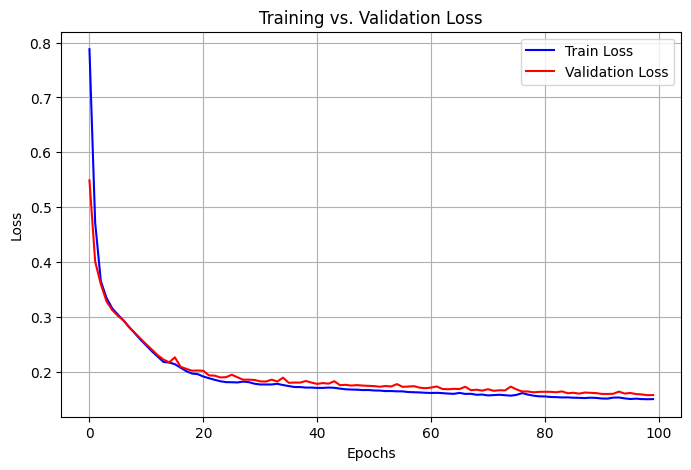

In [198]:
# plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Train Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [310]:
# define a smaller student model
def build_student_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # bottleneck (latent space)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

    # decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, outputs, name="Student_Autoencoder")

# sample usage
input_shape = (28, 28, 1)
student_autoencoder = build_student_autoencoder(input_shape)
student_autoencoder.summary()

Model: "Student_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_113 (InputLayer)         │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_341 (Conv2D)                  │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_221 (MaxPooling2D)     │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_342 (Conv2D)                  │ (None, 14, 14, 8)           │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_222 (MaxPooling2D)     │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_343 (Conv2D)                  │ (None, 7, 7, 4)             │             292 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_205 (UpSampling2D)     │ (None, 14, 14, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_264                 │ (None, 14, 14, 4)           │             148 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_206 (UpSampling2D)     │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_265                 │ (None, 28, 28, 8)           │             296 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_344 (Conv2D)                  │ (None, 28, 28, 1)           │              73 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,441 (13.44 KB)

 Trainable params: 3,441 (13.44 KB)

 Non-trainable params: 0 (0.00 B)

In [311]:
# implement knowledge distillation (KL)
from tensorflow.keras import backend as K

# define KL divergence loss
def kl_divergence_loss(y_true, y_pred):
    return K.sum(y_true * K.log(y_true / (y_pred + 1e-8) + 1e-8))

# define total knowledge distillation loss (produces negative and un normalized results)
# def knowledge_distillation_loss(y_true, y_pred, teacher_pred, alpha=0.5, beta=0.5):
#     mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
#     kl_loss = kl_divergence_loss(teacher_pred, y_pred)
#     return alpha * mse_loss + beta * kl_loss

# define total knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, teacher_pred, alpha=0.1, temperature=6):
  kl_div = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_pred / temperature, axis=-1),
                                          tf.nn.softmax(y_pred / temperature, axis=-1))
  mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
  return alpha * mse_loss + (1 - alpha) * kl_div


In [312]:
# train student autoencoder

# load teacher weights
teacher_autoencoder.load_weights("teacher_autoencoder.weights.h5")

# create student autoencoder
student_autoencoder = build_student_autoencoder((28, 28, 1))
student_autoencoder.compile(optimizer='adam', loss='mse')

# get teacher predictions
teacher_predictions = teacher_autoencoder.predict(x_train)

# train student to mimic teacher
for epoch in range(100):
    print(f"Epoch {epoch+1}/20")

    # train step with knowledge distillation loss
    with tf.GradientTape() as tape:
        student_predictions = student_autoencoder(x_train, training=True)
        loss = knowledge_distillation_loss(x_train, student_predictions, teacher_predictions)

    gradients = tape.gradient(loss, student_autoencoder.trainable_variables)
    student_autoencoder.optimizer.apply_gradients(zip(gradients, student_autoencoder.trainable_variables))

    print(f"Loss: {loss.numpy()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/20
Loss: 0.01349621545523405
Epoch 2/20
Loss: 0.013388206250965595
Epoch 3/20
Loss: 0.013323361054062843
Epoch 4/20
Loss: 0.0132929477840662
Epoch 5/20
Loss: 0.01325709093362093
Epoch 6/20
Loss: 0.013211602345108986
Epoch 7/20
Loss: 0.013155992142856121
Epoch 8/20
Loss: 0.013088719919323921
Epoch 9/20
Loss: 0.013009770773351192
Epoch 10/20
Loss: 0.01292258221656084
Epoch 11/20
Loss: 0.012835835106670856
Epoch 12/20
Loss: 0.012748169712722301
Epoch 13/20
Loss: 0.012652642093598843
Epoch 14/20
Loss: 0.012546173296868801
Epoch 15/20
Loss: 0.012428349815309048
Epoch 16/20
Loss: 0.012300889007747173
Epoch 17/20
Loss: 0.012164576910436153
Epoch 18/20
Loss: 0.012020112946629524
Epoch 19/20
Loss: 0.011866227723658085
Epoch 20/20
Loss: 0.011703893542289734
Epoch 21/20
Loss: 0.011533288285136223
Epoch 22/20
Loss: 0.011354658752679825
Epoch 23/20
Loss: 0.011168343015015125
Epoch 24/20
Loss: 0.010969819501042366
Epoch 25/20
Loss: 0.010754226706922054
E

In [313]:
# compare student vs. teacher performance
mse_teacher = np.mean((x_test - teacher_autoencoder.predict(x_test)) ** 2)
mse_student = np.mean((x_test - student_autoencoder.predict(x_test)) ** 2)

print(f"Teacher MSE: {mse_teacher:.5f}")
print(f"Student MSE: {mse_student:.5f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Teacher MSE: 0.00375
Student MSE: 0.01322


In [315]:
# load some anomalous test images
anomalous_images = load_images(glob.glob(f"./mvtec_ad/{category}/test/broken_small/*.png"))

print(x_test.shape)
print(anomalous_images.shape)

(20, 28, 28, 1)
(22, 28, 28, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


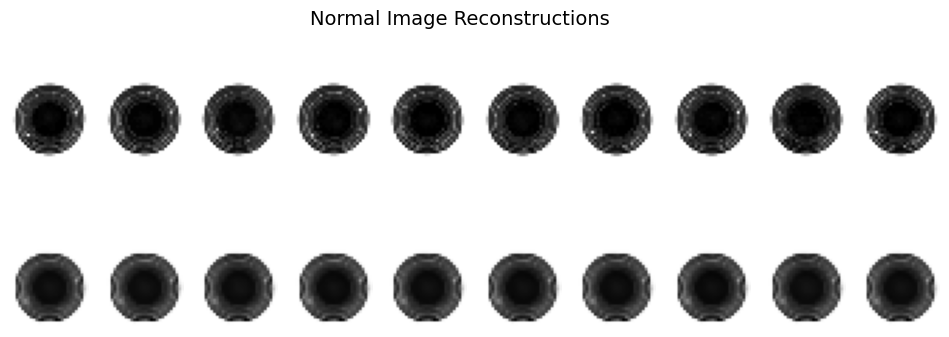

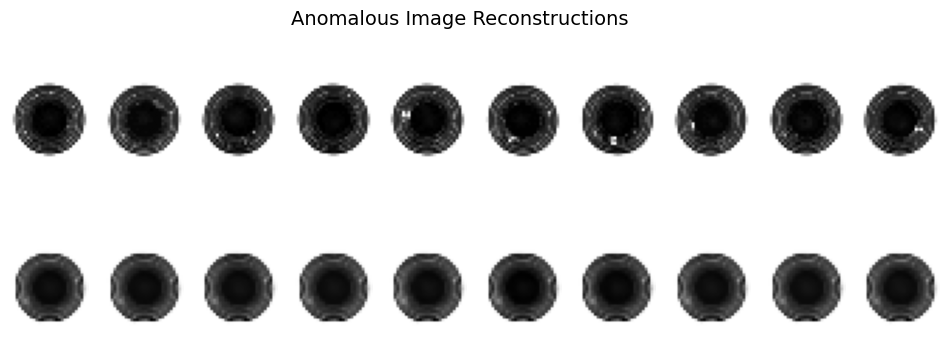

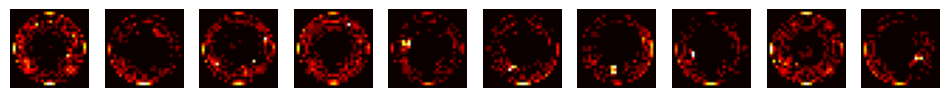

In [316]:
# reconstruct normal and anomalous images
normal_recon = teacher_autoencoder.predict(x_test[:20])  # Normal test images
anomalous_recon = teacher_autoencoder.predict(anomalous_images[:22])  # Defective images

# define function to plot results
def plot_anomaly_comparison(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    for i in range(10):
        # original image
        plt.subplot(2, 10, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.axis("off")

        # reconstructed image
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

# show normal vs reconstructed
plot_anomaly_comparison(x_test[:20], normal_recon, "Normal Image Reconstructions")

# show defective vs reconstructed
plot_anomaly_comparison(anomalous_images[:22], anomalous_recon, "Anomalous Image Reconstructions")

# plot error map
error_map = np.abs(anomalous_images[:22] - anomalous_recon)

# normalize per image
normalized_error_map = np.array([
    (error - np.min(error)) / (np.max(error) - np.min(error) + 1e-8)
    for error in error_map
])

# set treshold
threshold = 0.1
filtered_error_map = np.where(normalized_error_map > threshold, normalized_error_map, 0)

# show anomalous heatmap
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(filtered_error_map[i].squeeze(), cmap="hot")
    plt.axis("off")
plt.show()

In [317]:
import numpy as np

mse_normal = np.mean((x_test - normal_recon) ** 2, axis=(1,2,3))
mse_anomalous = np.mean((anomalous_images - anomalous_recon) ** 2, axis=(1,2,3))

print("Average MSE for normal images:", np.mean(mse_normal))
print("Average MSE for anomalous images:", np.mean(mse_anomalous))


Average MSE for normal images: 0.0037543557
Average MSE for anomalous images: 0.0060778763


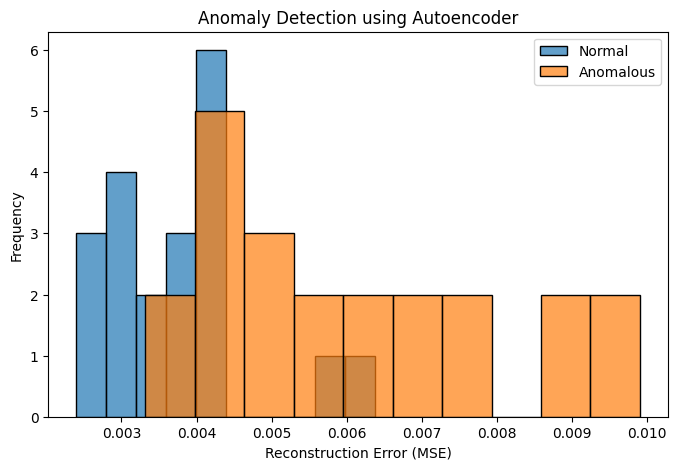

In [318]:
# visualize MSE distribution
plt.figure(figsize=(8,5))
sns.histplot(mse_normal, bins=10, alpha=0.7, label="Normal")
sns.histplot(mse_anomalous, bins=10, alpha=0.7, label="Anomalous")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Anomaly Detection using Autoencoder")
plt.legend()
plt.show()

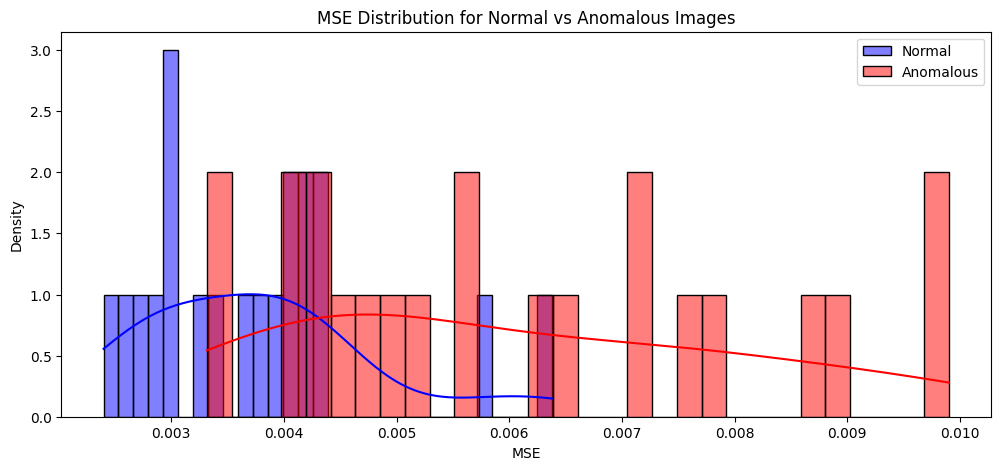

In [319]:
# plot MSE distributions
plt.figure(figsize=(12, 5))
sns.histplot(mse_normal, bins=30, color="blue", label="Normal", kde=True)
sns.histplot(mse_anomalous, bins=30, color="red", label="Anomalous", kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.legend()
plt.title("MSE Distribution for Normal vs Anomalous Images")
plt.show()

In [320]:
from skimage.metrics import structural_similarity as ssim

ssim_normal = [ssim(x_test[i].squeeze(), normal_recon[i].squeeze(), data_range=1.0) for i in range(10)]
ssim_anomalous = [ssim(anomalous_images[i].squeeze(), anomalous_recon[i].squeeze(), data_range=1.0) for i in range(10)]

print("SSIM for normal images:", np.mean(ssim_normal))
print("SSIM for anomalous images:", np.mean(ssim_anomalous))

SSIM for normal images: 0.9022664925345213
SSIM for anomalous images: 0.8484836017204958


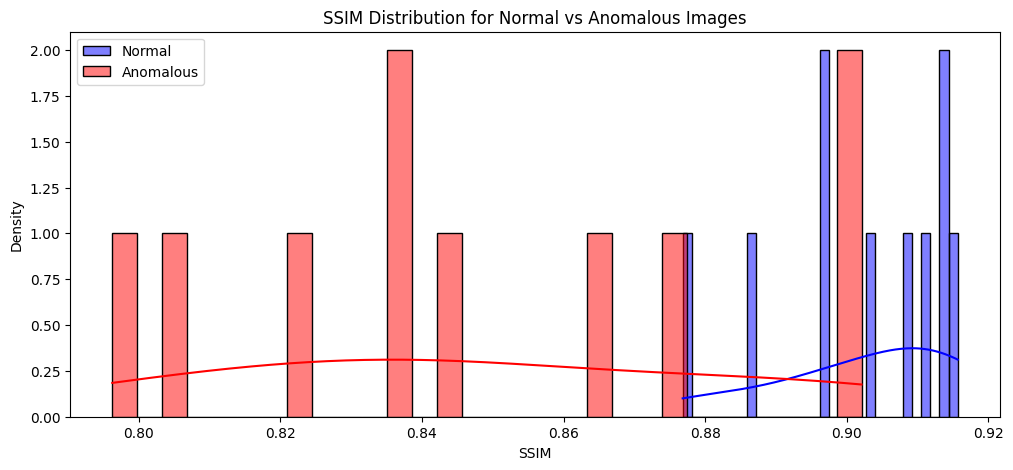

In [321]:
# plot SSIM distributions
plt.figure(figsize=(12, 5))
sns.histplot(ssim_normal, bins=30, color="blue", label="Normal", kde=True)
sns.histplot(ssim_anomalous, bins=30, color="red", label="Anomalous", kde=True)
plt.xlabel("SSIM")
plt.ylabel("Density")
plt.legend()
plt.title("SSIM Distribution for Normal vs Anomalous Images")
plt.show()

In [322]:
# set percentile thresholds (adjustable)
mse_threshold = np.percentile(mse_normal, 95)  # top 5% of normal MSE values
ssim_threshold = np.percentile(ssim_normal, 5)  #bBottom 5% of normal SSIM values

print(f"MSE Threshold: {mse_threshold}")
print(f"SSIM Threshold: {ssim_threshold}")

MSE Threshold: 0.005810188129544258
SSIM Threshold: 0.8812476747476857


In [323]:
mse_normal = np.array(mse_normal)[:10]
mse_anomalous = np.array(mse_anomalous)[:10]
ssim_normal = np.array(ssim_normal)
ssim_anomalous = np.array(ssim_anomalous)

# define anomaly score function
alpha = 0.5  # weight for SSIM
beta = 0.5   # weight for MSE

anomaly_scores_normal = alpha * (1 - ssim_normal) + beta * mse_normal
anomaly_scores_anomalous = alpha * (1 - ssim_anomalous) + beta * mse_anomalous

# compute threshold for combined anomaly score
anomaly_threshold = np.percentile(anomaly_scores_normal, 95)  # top 5% of normal scores

print(f"Anomaly Score Threshold: {anomaly_threshold}")


Anomaly Score Threshold: 0.06142548464502261


In [324]:
# classify images based on the anomaly score
normal_preds = anomaly_scores_normal > anomaly_threshold
anomalous_preds = anomaly_scores_anomalous > anomaly_threshold

# count correctly classified anomalies
true_positives = np.sum(anomalous_preds)  # anomalies detected correctly
false_negatives = len(anomalous_preds) - true_positives  # missed anomalies

# count correctly classified normal images
true_negatives = np.sum(~normal_preds)  # normal images detected correctly
false_positives = len(normal_preds) - true_negatives  # normal images wrongly classified as anomalies

# print results
print(f"True Positives (Correctly Identified Anomalies): {true_positives}")
print(f"False Negatives (Missed Anomalies): {false_negatives}")
print(f"True Negatives (Correctly Identified Normal): {true_negatives}")
print(f"False Positives (Normal Mistaken for Anomalies): {false_positives}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

True Positives (Correctly Identified Anomalies): 8
False Negatives (Missed Anomalies): 2
True Negatives (Correctly Identified Normal): 9
False Positives (Normal Mistaken for Anomalies): 1


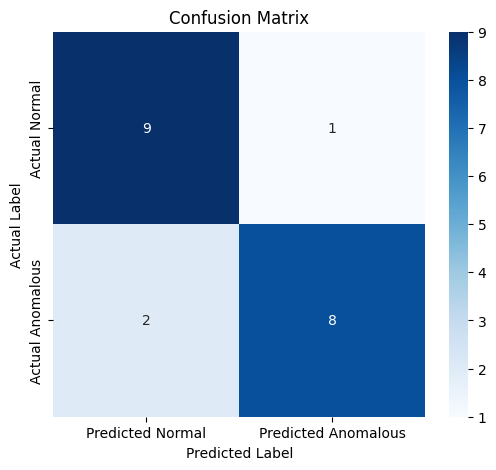

In [325]:
# create confusion matrix
conf_matrix = np.array([[true_negatives, false_positives],
                        [false_negatives, true_positives]])

# define labels
labels = ["Normal", "Anomalous"]
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Normal", "Predicted Anomalous"],
            yticklabels=["Actual Normal", "Actual Anomalous"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

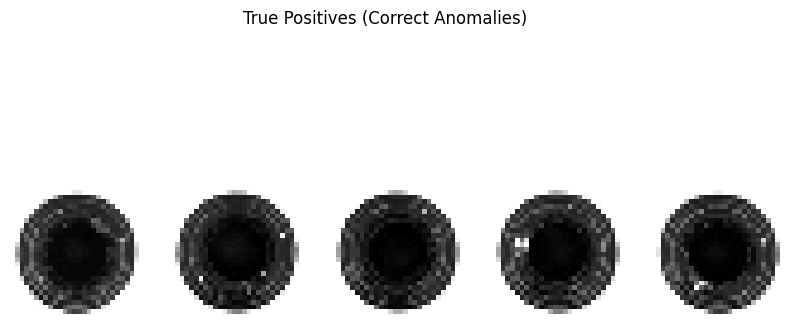

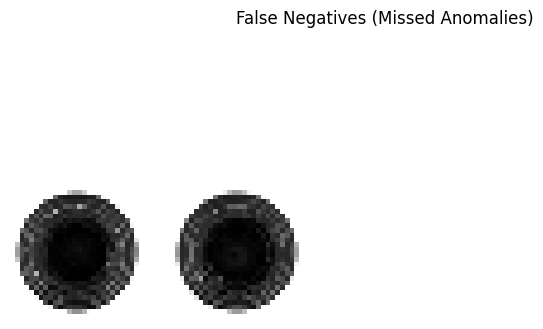

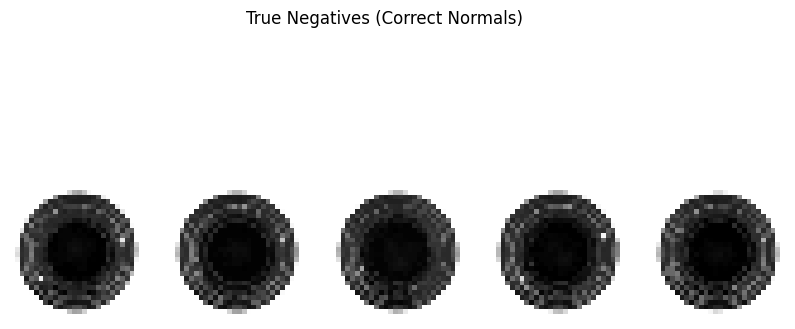

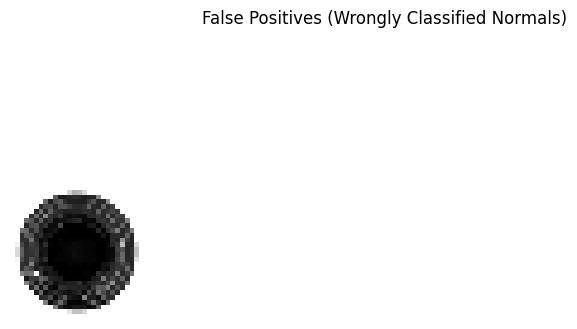

In [326]:
# get indices of classified images
true_positive_indices = np.where(anomalous_preds == True)[0]  # correctly identified anomalies
false_negative_indices = np.where(anomalous_preds == False)[0]  # missed anomalies
true_negative_indices = np.where(normal_preds == False)[0]  # correctly identified normal images
false_positive_indices = np.where(normal_preds == True)[0]  # normal images mistakenly classified as anomalies

# helper function to plot images
def plot_images(indices, dataset, title, num_images=5):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[:num_images]):  # show only the first `num_images`
        plt.subplot(1, num_images, i + 1)
        plt.imshow(dataset[idx].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# show correctly identified anomalies
plot_images(true_positive_indices, anomalous_images, "True Positives (Correct Anomalies)")

# show missed anomalies
plot_images(false_negative_indices, anomalous_images, "False Negatives (Missed Anomalies)")

# show correctly identified normal images
plot_images(true_negative_indices, x_test, "True Negatives (Correct Normals)")

# show normal images mistakenly classified as anomalies
plot_images(false_positive_indices, x_test, "False Positives (Wrongly Classified Normals)")